In [4]:
import torch
from torchvision.io import decode_image, ImageReadMode
from torchvision.transforms import InterpolationMode, Resize, ColorJitter, Normalize, GaussianBlur
import torchvision.transforms.v2.functional as F
import os
import random
import numpy as np
import cv2
import albumentations as A

class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, image_size=(256,256), mask_size=(256,256),
                 is_multiclass=True, augment=False, cache=False, border_mode=cv2.BORDER_REFLECT):
        super().__init__()
        self.image_size = image_size
        self.mask_size = mask_size
        self.is_multiclass = is_multiclass

        self.image_paths = sorted(
            [f for f in os.listdir(os.path.join(dataset_path, "images")) if not f.startswith(".")]
        )
        self.image_paths = [os.path.join(dataset_path, "images", f) for f in self.image_paths]
        
        self.mask_paths = sorted(
            [f for f in os.listdir(os.path.join(dataset_path, "masks")) if not f.startswith(".")]
        )
        self.mask_paths = [os.path.join(dataset_path, "masks", f) for f in self.mask_paths]

        self.resize_image = Resize(image_size, interpolation=InterpolationMode.BILINEAR)
        self.resize_mask  = Resize(mask_size, interpolation=InterpolationMode.NEAREST)
        
        self.augment = augment
        self.cache = cache
        self.cache_images = {} if cache else None
        self.cache_masks  = {} if cache else None

        self.normalize = Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
        
        self.transform = A.Compose([
            
                A.Rotate(limit=45, border_mode=border_mode, p=0.5),  # Reflect avoids constant fill
                A.ShiftScaleRotate(shift_limit=0.5, scale_limit=0.15, rotate_limit=0, border_mode=border_mode, p=0.5),  # Wrap mode
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5)
            ], additional_targets={'mask': 'mask'}) 
        self.transform.is_check_shapes=False
    def __getitem__(self, index):
        image = None
        mask = None
        if self.cache and index in self.cache_images:
            image = self.cache_images[index]
            mask = self.cache_masks[index]
        else:
            # Read image using OpenCV (BGR format) and convert to RGB
            image = cv2.imread(self.image_paths[index], cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
            
            # Read mask using OpenCV (grayscale)
            mask = cv2.imread(self.mask_paths[index], cv2.IMREAD_GRAYSCALE).astype(np.float32)

            image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask,  self.mask_size, interpolation=cv2.INTER_NEAREST)
            
            if self.is_multiclass:
                mask = mask.astype(np.int64)
            else:
                mask /= 255.0
 
            if self.cache:
                self.cache_images[index] = image
                self.cache_masks[index] = mask

        if self.augment:
            
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
      
        image = torch.from_numpy(image).permute(2,0,1)    
        image = self.normalize(image)
        
        return image, torch.from_numpy(mask).unsqueeze(0).long()

    def __len__(self):
        return len(self.image_paths)


/Users/amalahmadinurov/Desktop/Subjects_ZS_2025/ZNEUS/tiger-challenge-segmentation/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
DATASET_PATH = "/Users/amalahmadinurov/Desktop/Subjects_ZS_2025/ZNEUS/tiger-patches/patches/"
IMG_SIZE = (256,256)
MASK_SIZE = (256,256)





/Users/amalahmadinurov/Desktop/Subjects_ZS_2025/ZNEUS/tiger-challenge-segmentation/.venv/lib/python3.13/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


/Users/amalahmadinurov/Desktop/Subjects_ZS_2025/ZNEUS/tiger-challenge-segmentation/.venv/lib/python3.13/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


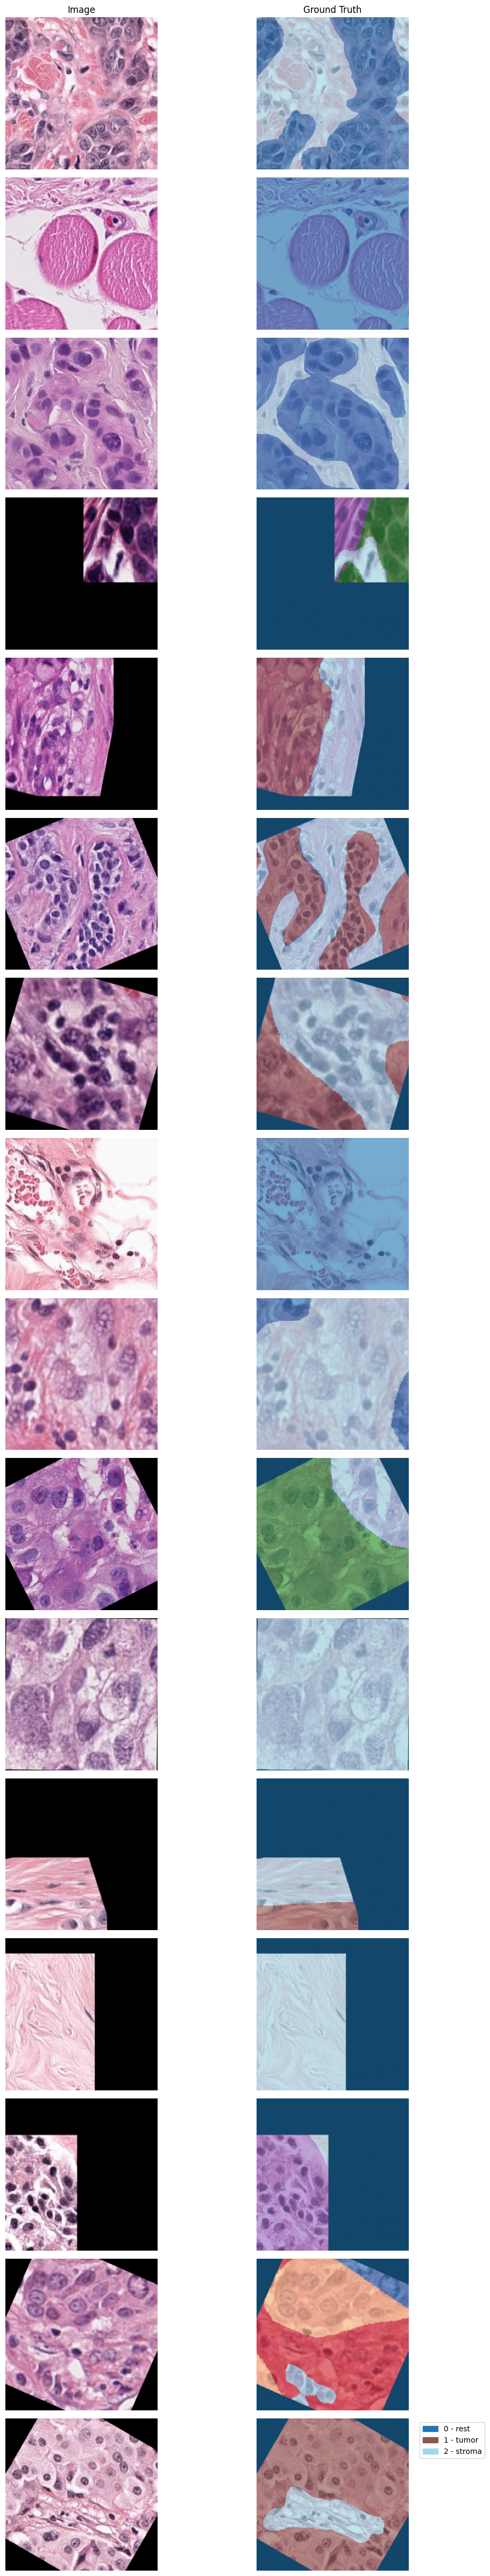

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

dataset = SegmentationDataset(DATASET_PATH,image_size=IMG_SIZE, mask_size=IMG_SIZE, augment=True, is_multiclass=True, cache=True, border_mode=cv2.BORDER_CONSTANT)

from torch.utils.data import DataLoader

def denormalize(tensor, mean, std):
    mean = torch.tensor(mean, device=tensor.device).view(1, -1, 1, 1)
    std = torch.tensor(std, device=tensor.device).view(1, -1, 1, 1)
    return tensor * std + mean

# Load a normal batch
val_dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0
)

images, ground_truth = next(iter(val_dataloader))



# Format masks
ground_truth = ground_truth.squeeze(1).cpu().numpy()   # (B, H, W)
                          # (B, H, W)

# Denormalize and convert to (B, H, W, C)
images_denorm = denormalize(
    images,
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
).cpu().numpy()
images_denorm = np.transpose(images_denorm, (0, 2, 3, 1))

# Plotting
num_samples = len(images_denorm)
classes_names = {0: "rest", 1: "tumor", 2: "stroma", }
cmap = plt.get_cmap("tab20", len(classes_names))

fig, axes = plt.subplots(num_samples, 2, figsize=(12, 3 * num_samples))
if num_samples == 1:
    axes = axes.reshape(1, 3)

column_titles = ["Image", "Ground Truth"]
for col, title in enumerate(column_titles):
    axes[0, col].set_title(title, fontsize=12)

for i in range(num_samples):
    axes[i, 0].imshow(images_denorm[i])
    axes[i, 1].imshow(images_denorm[i])
    axes[i, 1].imshow(ground_truth[i], cmap="tab20", alpha=0.6)
    
 

    for col in range(2):
        axes[i, col].axis("off")

# Legend
patches = [
    mpatches.Patch(color=cmap(i), label=f"{i} - {name}")
    for i, name in classes_names.items()
]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


/Users/amalahmadinurov/Desktop/Subjects_ZS_2025/ZNEUS/tiger-challenge-segmentation/.venv/lib/python3.13/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


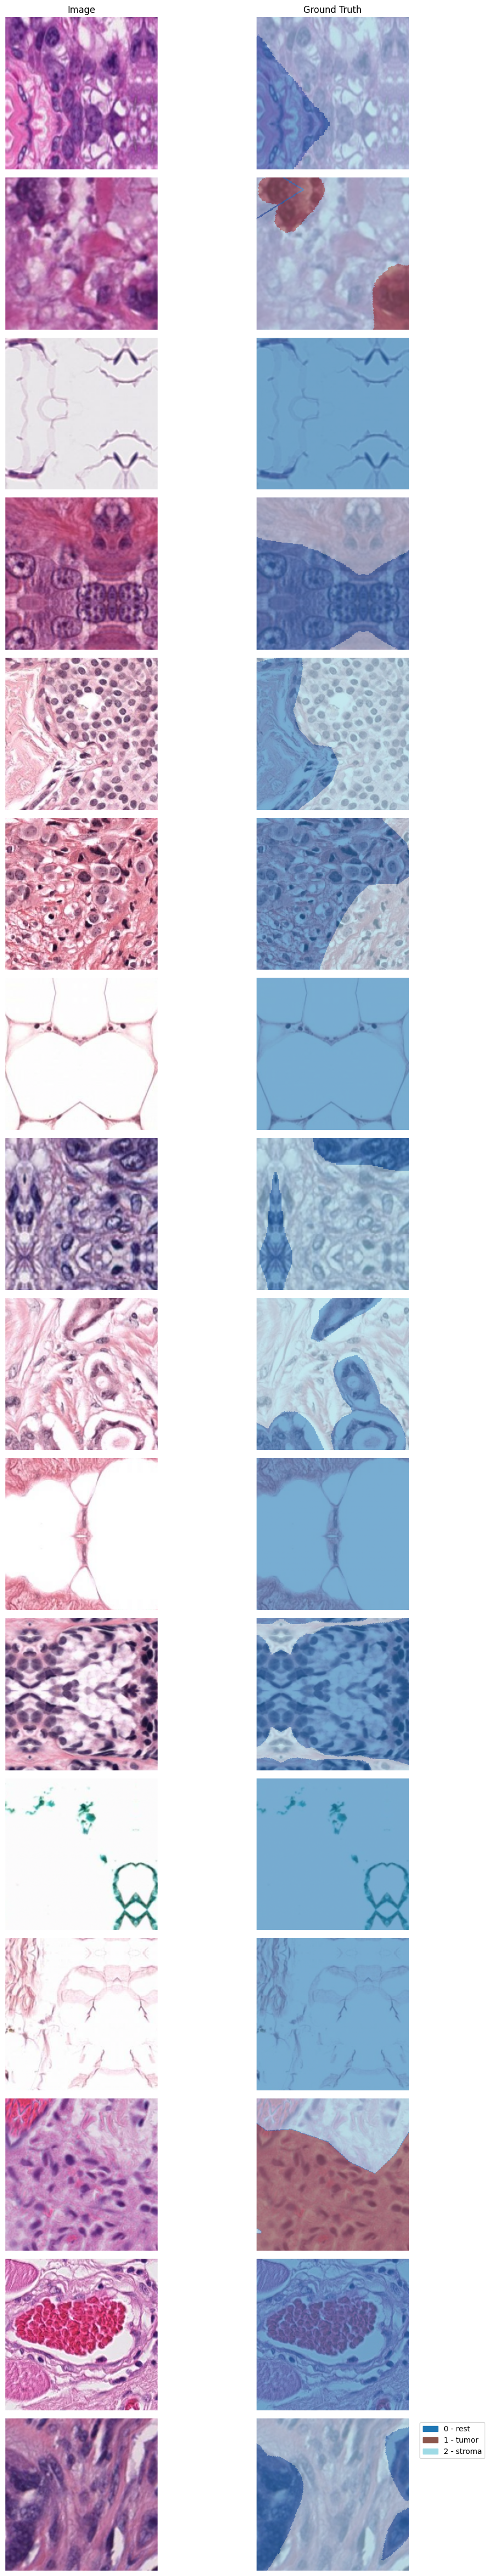

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

dataset = SegmentationDataset(DATASET_PATH,image_size=IMG_SIZE, mask_size=IMG_SIZE, augment=True, is_multiclass=True, cache=True, border_mode=cv2.BORDER_REFLECT)

from torch.utils.data import DataLoader

def denormalize(tensor, mean, std):
    mean = torch.tensor(mean, device=tensor.device).view(1, -1, 1, 1)
    std = torch.tensor(std, device=tensor.device).view(1, -1, 1, 1)
    return tensor * std + mean

# Load a normal batch
val_dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0
)

images, ground_truth = next(iter(val_dataloader))



# Format masks
ground_truth = ground_truth.squeeze(1).cpu().numpy()   # (B, H, W)
                          # (B, H, W)

# Denormalize and convert to (B, H, W, C)
images_denorm = denormalize(
    images,
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
).cpu().numpy()
images_denorm = np.transpose(images_denorm, (0, 2, 3, 1))

# Plotting
num_samples = len(images_denorm)
classes_names = {0: "rest", 1: "tumor", 2: "stroma", }
cmap = plt.get_cmap("tab20", len(classes_names))

fig, axes = plt.subplots(num_samples, 2, figsize=(12, 3 * num_samples))
if num_samples == 1:
    axes = axes.reshape(1, 3)

column_titles = ["Image", "Ground Truth"]
for col, title in enumerate(column_titles):
    axes[0, col].set_title(title, fontsize=12)

for i in range(num_samples):
    axes[i, 0].imshow(images_denorm[i])
    axes[i, 1].imshow(images_denorm[i])
    axes[i, 1].imshow(ground_truth[i], cmap="tab20", alpha=0.6)
    
 

    for col in range(2):
        axes[i, col].axis("off")

# Legend
patches = [
    mpatches.Patch(color=cmap(i), label=f"{i} - {name}")
    for i, name in classes_names.items()
]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()
